# Please go to https://github.com/kvchen/stats202_final for a more readable version of these notebooks.

# Data Exploration

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import plot_importance

from lib import data

pd.options.display.max_columns = None
sns.set()

In [118]:
df = data.read_train_data()
combined_df = pd.concat([
    data.read_train_data().drop(['LeadStatus'], axis=1),
    data.read_test_data(),
])

In [11]:
df.head()

,Study,Country,PatientID,SiteID,RaterID,TxGroup,VisitDay,P1,P2,P3,P4,P5,P6,P7,N1,N2,N3,N4,N5,N6,N7,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,PANSS_Total,LeadStatus
AssessmentiD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100679,A,USA,10001,20035,30076,Control,0,5,5,5,3,4,5,3,4,4,3,4,4,3,2,3,4,4,4,1,4,1,3,5,3,3,4,3,3,3,5,107,Assign to CS
101017,A,USA,10001,20035,30076,Control,11,5,5,5,3,4,5,3,4,4,3,4,4,3,3,4,4,4,4,1,4,1,3,5,3,3,4,3,3,3,5,109,Assign to CS
102177,A,USA,10001,20035,30076,Control,18,4,4,4,3,2,4,2,4,4,3,4,4,3,2,3,3,3,3,1,4,2,2,4,2,2,3,3,2,3,4,91,Passed
101533,A,USA,10001,20035,30076,Control,25,3,3,3,2,2,4,2,4,4,2,4,4,2,2,3,3,2,2,1,2,2,2,3,2,2,3,3,2,3,4,80,Flagged
100930,A,USA,10001,20035,30076,Control,39,3,3,4,2,1,4,2,4,4,2,4,4,1,2,3,3,1,2,1,1,2,2,3,2,2,3,3,2,3,4,77,Flagged


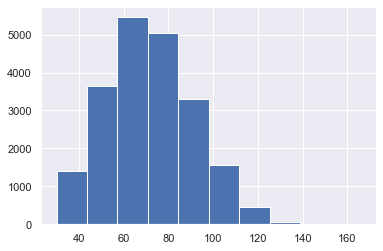

In [12]:
df.PANSS_Total.hist()

Text(0, 0.5, 'Patient Count')

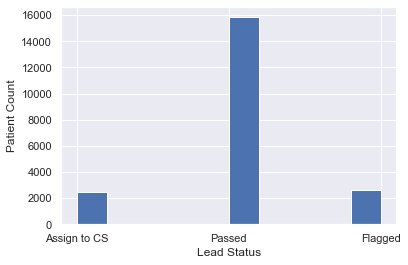

In [142]:
df.LeadStatus.hist()

plt.xlabel('Lead Status')
plt.ylabel('Patient Count')

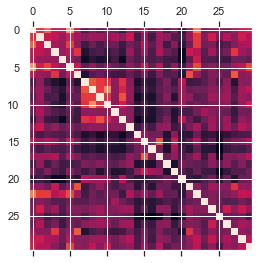

In [16]:
plt.matshow(df.filter(regex=("(P|N|G)\d+")).corr())

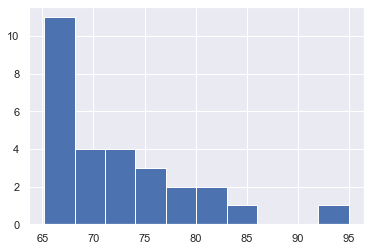

In [40]:
df.groupby(['Country']).PANSS_Total.agg('mean').hist()

In [41]:
visit_dist = df.groupby('PatientID').agg('last').groupby('TxGroup').VisitDay
visit_dist.describe()

,count,mean,std,min,25%,50%,75%,max
TxGroup,,,,,,,,
Control,1224.0,144.053105,118.852766,0.0,46.00,113.5,203.0,480.0
Treatment,1210.0,144.171074,118.901352,0.0,44.25,117.0,207.0,479.0


Text(0, 0.5, 'Patient Count')

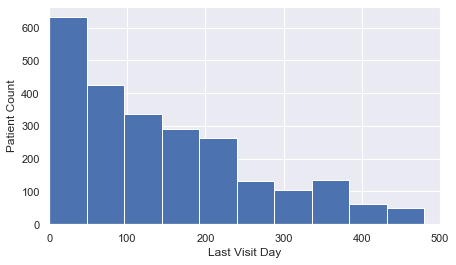

In [97]:
f, ax = plt.subplots(figsize=(7, 4))

ax.set_xlim([0, 500])
plt.hist(df.groupby('PatientID').agg('last').VisitDay)

plt.xlabel('Last Visit Day')
plt.ylabel('Patient Count')

Text(0, 0.5, 'Patient Count')

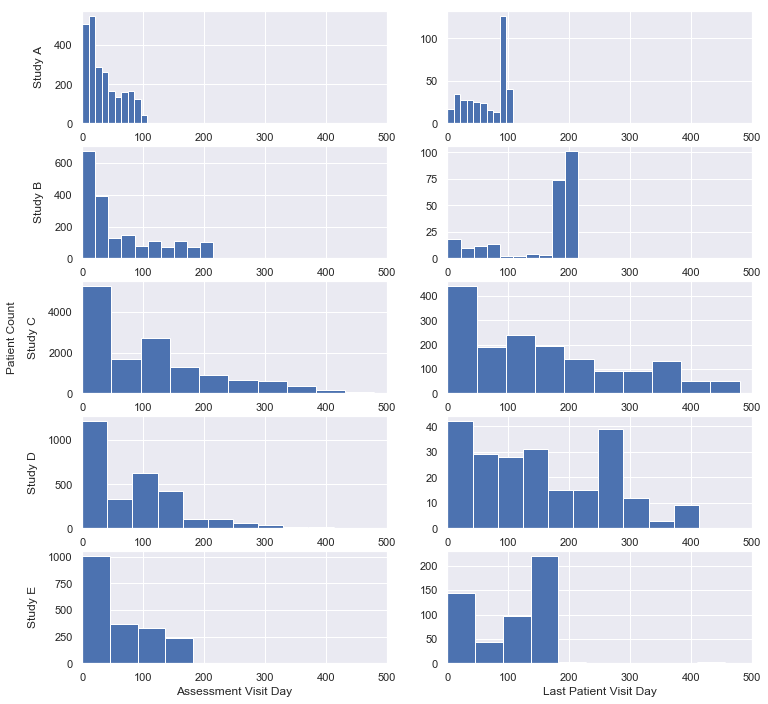

In [141]:
studies = combined_df.Study.unique()
f, axes = plt.subplots(len(studies), 2, figsize=(12, 12))

for idx, study in enumerate(sorted(studies)):
    temp = combined_df[combined_df.Study == study]
    
    axes[idx, 0].set_xlim([0, 500])
    axes[idx, 0].hist(temp.VisitDay)
    axes[idx, 0].set_xlabel('Assessment Visit Day')
    axes[idx, 0].set_ylabel(f"Study {study}", labelpad=10)

    axes[idx, 1].set_xlim([0, 500])
    axes[idx, 1].hist(temp.groupby('PatientID').agg('last').VisitDay)
    axes[idx, 1].set_xlabel('Last Patient Visit Day')
    
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Patient Count", labelpad=40)

In [48]:
combined = pd.concat([
    data.read_train_data().drop(['LeadStatus']),
    data.read_test_data(),
])

combined.groupby('Study').agg(['min', 'max', 'nunique'])

Country                  PatientID                 SiteID  \
                  min      max nunique       min    max nunique     min   
Study                                                                     
A                 USA      USA       1     10001  10351     351   20001   
B      Czech Republic  Ukraine       7     20001  20240     240   40001   
C           Argentina  Ukraine      27     30001  31620    1620   60001   
D               China    China       1     40001  40223     223   80001   
E              Russia      USA       3     50001  50513     513  100001   

                      RaterID                  TxGroup                     \
          max nunique     min     max nunique      min        max nunique   
Study                                                                       
A       20042      42   30001   30081      81  Control  Treatment       2   
B       40041      41   60001   60065      65  Control  Treatment       2   
C       60200     200   90001   90443     443  Control  Treatment       2   
D       80001       1  120001  120050      50  Control  Treatment       2   
E      100061      61  150001  150139     137  Control  Treatment       2   

      VisitDay               P1              P2              P3              \
           min  max nunique min max nunique min max nunique min max nunique   
Study                                                                         
A            0  107      96   1   7       7   1   7       7   1   7       7   
B            0  215     154   1   7       7   1   6       6   1   7       7   
C            0  480     443   1   7       7   1   6       6   1   7       7   
D            0  413     288   1   7       7   1   7       7   1   7       7   
E            0  456     150   1   6       6   1   5       5   1   5       5   

       P4              P5              P6              P7              N1      \
      min max nunique min max nunique min max nunique min max nunique min max   
Study                                                                           
A       1   6       6   1   6       6   1   7       7   1   7       7   1   6   
B       1   6       6   1   7       7   1   7       7   1   5       5   1   6   
C       1   7       7   1   7       7   1   7       7   1   7       7   1   6   
D       1   6       6   1   7       7   1   7       7   1   7       7   1   7   
E       1   5       5   1   6       6   1   5       5   1   5       5   1   6   

               N2              N3              N4              N5              \
      nunique min max nunique min max nunique min max nunique min max nunique   
Study                                                                           
A           6   1   7       7   1   7       7   1   7       7   1   7       7   
B           6   1   6       6   1   6       6   1   6       6   1   7       7   
C           6   1   6       6   1   6       6   1   7       7   1   7       7   
D           7   1   7       7   1   7       7   1   7       7   1   7       7   
E           6   1   6       6   1   6       6   1   6       6   1   6       6   

       N6              N7              G1              G2              G3      \
      min max nunique min max nunique min max nunique min max nunique min max   
Study                                                                           
A       1   6       6   1   7       7   1   6       6   1   6       6   1   6   
B       1   6       6   1   7       7   1   6       6   1   6       6   1   5   
C       1   7       7   1   6       6   1   7       7   1   7       7   1   6   
D       1   7       7   1   6       6   1   6       6   1   7       7   1   6   
E       1   6       6   1   5       5   1   5       5   1   5       5   1   5   

               G4              G5              G6              G7              \
      nunique min max nunique min max nunique min max nunique min max nunique   
Study                                                 